In [83]:
# Prevent codes being displayed when exporting to an HTML file
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) {jQuery(".input_area").toggle(); jQuery(".prompt").toggle();} jQuery(".highlight").show();});</script>', raw=True)

# Dynamically add a button to show/hide codes
di.display_html("<script>jQuery(function() {jQuery(function() {var b = jQuery('<input type=\"button\" value=\"Show/Hide codes\"/>'); b.click(function(){jQuery('.input_area').each(function(){jQuery(this).toggle();});}); jQuery('#References').parent().append(b);});});</script>", raw=True)

## References

# Part 1: Popularity Prediction

## Load Data

In [2]:
import json
import os

# access all the files in folder "tweet_data"
folder_path = "./tweet_data" 
files= os.listdir(folder_path) # all the file name in the folder
all_tweets = {}

for file in files: 
     if not os.path.isdir(file): # open file if it is not a folder
        f = open(folder_path + "/" + file) # open a file
        templist = []
        key = file[7:-4]
        for line in f.readlines(): 
            tweet = json.loads(line)
            templist.append(tweet)
        all_tweets.setdefault(key, list)
        all_tweets[key] = templist
        f.close()
        print("done!")
print (len(all_tweets))
#print (all_tweets.keys())
#print (type(all_tweets['#nfl']))
print(len(all_tweets['#nfl']))


done!
done!
done!
done!
done!
done!
6
259024


## Extract Features & Output Feature Vectors to Files

In [1]:
import numpy as np
import math
import datetime, time
import pytz

def feature_extract_perhour(start_time, end_time, tweetfile): 
    # only consider a part of the data, not every tweets in the file
    total_hours = (end_time - start_time) / 3600 + 1
    # print(total_hours)
    tweets_totalnum_perhour = [0 for i in range(total_hours)]
    retweets_num_perhour = [0 for i in range(total_hours)]
    followers_totalnum_perhour = [0 for i in range(total_hours)]
    followers_maxnum_perhour = [0 for i in range(total_hours)]
    time_of_day_perhour = [None for i in range(total_hours)]
    timestamp_perhour = []
    ts = start_time
    for i in range(total_hours):
        timestamp_perhour.append(ts)
        ts += 3600
    pst_tz = pytz.timezone('US/Pacific') 
    
    for tweet in tweetfile: 
        tweet_time = tweet['citation_date']
        if (tweet_time >= start_time and tweet_time <= end_time):
            #hour = int((tweet_time - po_time_min)/3600)
            hour = int((tweet_time - start_time) / 3600)
            tweets_totalnum_perhour[hour] += 1
            retweets_num_perhour[hour] += tweet['tweet']['retweet_count']
            followers_totalnum_perhour[hour] += tweet['author']['followers']
            if (tweet['author']['followers'] >= followers_maxnum_perhour[hour]):
                followers_maxnum_perhour[hour] = tweet['author']['followers']
            if (time_of_day_perhour[hour] == None):
                # make the earliest time in each interval as the feature time_of_the_day 
                earliest_date = datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz)
                time_of_day_perhour[hour] = earliest_date.hour
    feat_5 = [tweets_totalnum_perhour[0:-1], retweets_num_perhour[0:-1], followers_totalnum_perhour[0:-1],\
              followers_maxnum_perhour[0:-1],time_of_day_perhour[0:-1]]
    gt_y = tweets_totalnum_perhour[1:]
    return timestamp_perhour[0:-1], feat_5, gt_y


# extract features
def extract_features(start_time, end_time, tweetfile): 

    total_hours = int((end_time - start_time) / 3600) + 1
    # other features:
    ori_author_followers = [0 for i in range(total_hours)] # total number of followers of the original author
    favorited_num = [0 for i in range(total_hours)] # total number of times of favorited, so many zeros
    impressions_num = [0 for i in range(total_hours)]
    avg_ranking_score = [0 for i in range(total_hours)]
    user_mentions = [0 for i in range(total_hours)]
    url_count = [0 for i in range(total_hours)]
    unique_author_set = [set() for i in range(total_hours)] # save unique author 
    
    # extract five basic features
    index, feat_5, gt_y = feature_extract_perhour(start_time, end_time, tweetfile)

    # extract other features
    for tweet in tweetfile:
        tweet_time = tweet['citation_date']
        if (tweet_time >= start_time and tweet_time <= end_time):
            hour = int((tweet_time - start_time) / 3600)
            ori_author_followers[hour] += tweet['original_author']['followers']
            favorited_num[hour] += tweet['tweet']['favorite_count']
            user_mentions[hour] += len(tweet['tweet']['entities']['user_mentions'])
            url_count[hour] += len(tweet['tweet']['entities']['urls'])
            unique_author_set[hour].add(tweet['author']['nick'])
            impressions_num[hour] += tweet['metrics']['impressions']
            avg_ranking_score[hour] += tweet['metrics']['ranking_score'] # need to do average later
            
    total_tweets = feat_5[0]
    for i in range(0, len(total_tweets)):
        if(total_tweets[i] != 0):
            avg_ranking_score[i] = avg_ranking_score[i] / total_tweets[i]
    
    unique_author_count =  [len(val) for val in unique_author_set]  # number of unique authors
    feat_extra = [ori_author_followers[0:-1], favorited_num[0:-1], \
                  user_mentions[0:-1], url_count[0:-1], unique_author_count[0:-1],\
                  impressions_num[0:-1],avg_ranking_score[0:-1]]

    feat_all = feat_5 + feat_extra

    return index, feat_all, gt_y

# extract Standard time interval by citation time 
pst_tz = pytz.timezone('US/Pacific') 
round_timestamp_to_hour = lambda t: int(time.mktime(datetime.datetime.fromtimestamp(t, pst_tz).replace(microsecond=0,second=0,minute=0).timetuple()))

mins = {}
maxs = {}
for key in all_tweets.keys():
    tmp_min = all_tweets[key][0]['citation_date']
    tmp_max = 0
    for tweet in all_tweets[key]:
        tmp_min = min(tmp_min, tweet['citation_date'])
        tmp_max = max(tmp_max, tweet['citation_date'])
    mins[key] = round_timestamp_to_hour(tmp_min)
    maxs[key] = round_timestamp_to_hour(tmp_max)

indexs, Xs, ys = [], [], []
for key in all_tweets.keys():
    index, X, y = extract_features(mins[key], maxs[key], all_tweets[key])
    X = features_transform(X)
    y = np.array(y)
    indexs.append(index)
    Xs.append(X)
    ys.append(y)
    idx1, idx2 = index.index(time1), index.index(time2)

pickle.dump(indexs, open("indexs.txt", "w"))
pickle.dump(Xs, open("Xs.txt", "w"))
pickle.dump(ys, open("ys.txt", "w"))

NameError: name 'all_tweets' is not defined

## Calculate Statistics (Problem 1.1)

In [2]:
import pickle
import numpy as np
filepath = "./Xs.txt"
with open(filepath, 'rb') as file:
    Xs = pickle.load(file, encoding='latin1')

file.close()

def statistics(Xs,index):
    avg_tweets_num = np.mean(Xs[index][:,0])
    avg_followers_num = sum(Xs[index][:,2]) / sum(Xs[index][:,0])
    avg_retweets_num = sum(Xs[index][:,1]) / sum(Xs[index][:,0])
    return avg_tweets_num, avg_followers_num, avg_retweets_num

In [3]:
# print all the statistics

index = 0
all_tweets = {'#gohawks': [], '#gopatriots':[], '#nfl':[], '#patriots':[], '#sb49':[], '#superbowl':[]}
for key in all_tweets.keys():
    print(key + ":")
    avg_tweets_num, avg_folloers_num, avg_retweets_num = statistics(Xs,index)
    print ("Average number of tweets per hour:", avg_tweets_num)
    print ("Average number of followers of users posting the tweets:",avg_folloers_num)
    print ("Average number of retweets:",  avg_retweets_num )
    index += 1

#gohawks:
Average number of tweets per hour: 325.493079585
Average number of followers of users posting the tweets: 2203.94157919
Average number of retweets: 0.209163632498
#gopatriots:
Average number of tweets per hour: 45.6986062718
Average number of followers of users posting the tweets: 1401.94895353
Average number of retweets: 0.0268384735618
#nfl:
Average number of tweets per hour: 442.011945392
Average number of followers of users posting the tweets: 4653.33254317
Average number of retweets: 0.0509383481521
#patriots:
Average number of tweets per hour: 835.682593857
Average number of followers of users posting the tweets: 3309.89769251
Average number of retweets: 0.0914622940107
#sb49:
Average number of tweets per hour: 1420.79896907
Average number of followers of users posting the tweets: 10267.1800848
Average number of retweets: 0.178022868407
#superbowl:
Average number of tweets per hour: 2301.64846416
Average number of followers of users posting the tweets: 8858.94910533
Ave

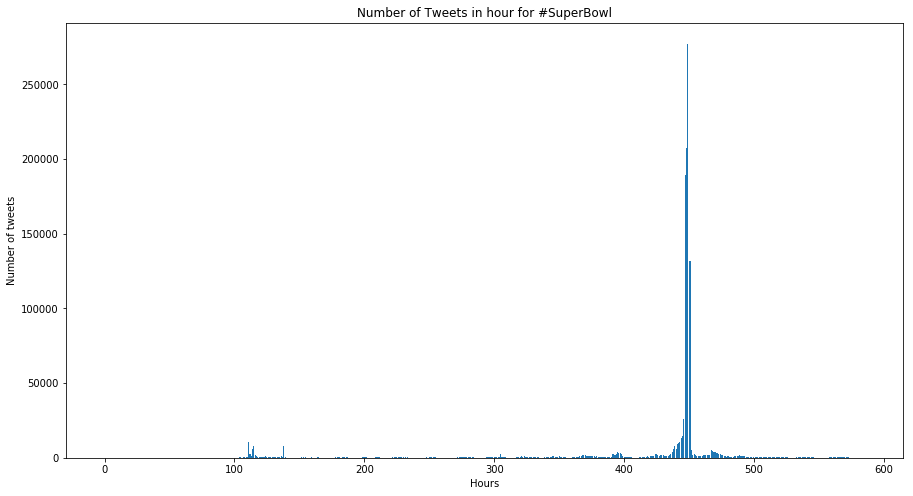

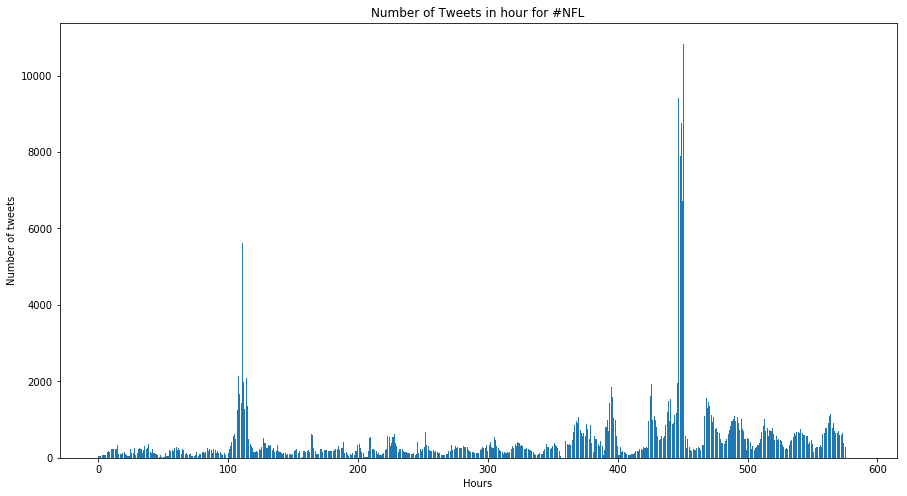

In [10]:
# plot

%matplotlib inline
import matplotlib.pyplot as plt

#SuperBowl 
tweets_num_perhour = Xs[5][:,0]

plt.figure(figsize=(15, 8))
plt.bar(range(len(tweets_num_perhour)), tweets_num_perhour)
plt.title("Number of Tweets in hour for #SuperBowl")
plt.ylabel("Number of tweets")
plt.xlabel("Hours")
plt.show()

#NFL
tweets_num_perhour = Xs[2][:,0]
plt.figure(figsize=(15, 8))
plt.bar(range(len(tweets_num_perhour)), tweets_num_perhour)
plt.title("Number of Tweets in hour for #NFL")
plt.ylabel("Number of tweets")
plt.xlabel("Hours")
plt.show()


## Predict Number of Tweets in the Next Hour (Problem 1.2 & Problem 1.3)

In [4]:
# plot best 3 features
def plot_best_feat(gt_y, feat1, feat2, feat3, feat_names):
    plt.gca().scatter(gt_y, feat1)
    plt.xlabel('Feature : ' + feat_names[0])
    plt.ylabel('Tweets for next hour')
    plt.show()

    plt.gca().scatter(gt_y, feat2)
    plt.xlabel('Feature : ' + feat_names[1])
    plt.ylabel('Tweets for next hour')
    plt.show()

    plt.gca().scatter(gt_y, feat3)
    plt.xlabel('Feature : ' + feat_names[2])
    plt.ylabel('Tweets for next hour')
    plt.show()

## #gohawks

### 5 features

In [28]:
import statsmodels.api as sm
import math

def feature_5_transform(x):
    # turn list of list (5 features) into 2-D matrix: each row represents one 
    # reocrd(statistics for the one-hour interval), and add "1" to each row as bias
    # deal with the intervals without tweets, set it as the value of previous interval plus 1
    for i in range(len(x[-1])):
        if x[-1][i] == None:
            x[-1][i] = (x[-1][i - 1] + 1) % 24
    X = np.array(x)
    X = np.transpose(X)
    return X

def feature_all_transform(x):
    # turn list of list (all features) into 2-D matrix: each row represents one 
    # reocrd(statistics for the one-hour interval), and add "1" to each row as bias
    # deal with the intervals without tweets, set it as the value of previous interval plus 1
    for i in range(len(x[4])):
        if x[4][i] == None:
            x[4][i] = (x[4][i - 1] + 1) % 24
    #X = np.array(x)
    X = np.transpose(X)
    return X
#fit model

def lr_model(y, x):    

    x = sm.add_constant(x)  # construct constant value in regression function 
    results = sm.regression.linear_model.OLS(y, x).fit()
    return results


filepath = "./ys.txt"
with open(filepath, 'rb') as file:
    ys = pickle.load(file, encoding='latin1')

file.close()


gohawks_X_5 = Xs[0][:-1,0:5]
gohawks_y = ys[0][0:-1]

print(len(gohawks_X_5),len(gohawks_y))


gohawks_model_5 = lr_model(gohawks_y, gohawks_X_5)
print (gohawks_model_5.summary())
print ("\n")

# RMSE
y_pre = gohawks_model_5.fittedvalues
y_train = gohawks_y[:-1]
gohawks_5_RMSE = math.sqrt(np.mean(y_train - y_pre[1:]) ** 2)
print("RMSE: %f \n" % gohawks_5_RMSE)
print("R-squared: %f \n" % gohawks_model_5.rsquared)
print("p_values:\n")
print("%s\n" % gohawks_model_5.pvalues)
print("t_values:\n")
print("%s\n" % gohawks_model_5.tvalues)


577 577
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     99.33
Date:                Mon, 19 Mar 2018   Prob (F-statistic):           2.94e-75
Time:                        16:19:40   Log-Likelihood:                -4793.0
No. Observations:                 577   AIC:                             9598.
Df Residuals:                     571   BIC:                             9624.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        115.2343     79.683      1.446 

### all features

In [29]:

#gohawks_X_all, gohawks_y = extract_features(start_time, end_time, all_tweets['#gohawks'])
#gohawks_X_all = feature_all_transform(gohawks_X_all)
gohawks_X_all = Xs[0][:-1]
gohawks_model = lr_model(gohawks_y, gohawks_X_all)
print (gohawks_model.summary())

# RMSE
y_pre = gohawks_model.fittedvalues

gohawks_RMSE = math.sqrt(np.mean(y_train - y_pre[1:]) ** 2)
#gohawks_RMSE = math.sqrt(np.mean((gohawks_y - y_pre) ** 2))
print("\n")
print("RMSE: %f \n" % gohawks_RMSE)
print("R-squared: %f \n" % gohawks_model.rsquared)
print("p_values:\n")
print("%s\n" % gohawks_model.pvalues)
print("t_values:\n")
print("%s\n" % gohawks_model.tvalues)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     61.99
Date:                Mon, 19 Mar 2018   Prob (F-statistic):           9.14e-95
Time:                        16:19:51   Log-Likelihood:                -4730.9
No. Observations:                 577   AIC:                             9488.
Df Residuals:                     564   BIC:                             9544.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -168.8591    281.766     -0.599      0.5

### plot top three features

In [21]:
print(gohawks_X_all.shape)

(577, 12)


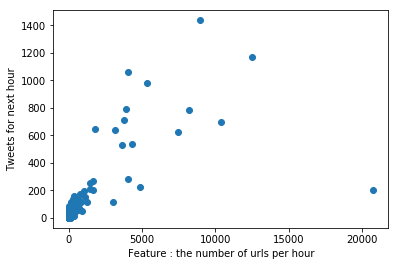

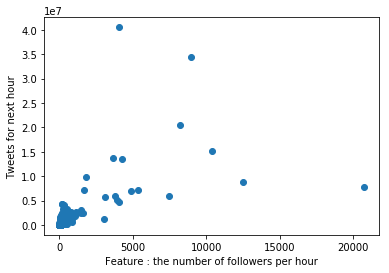

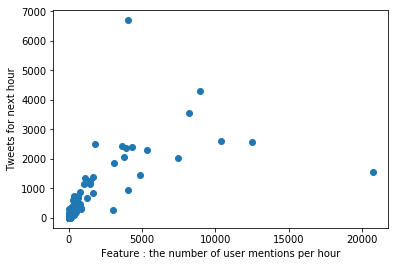

In [36]:
# top 3 features of all the features(11) according to the fitting report
# chose features with tiny p-value
# notice: const item is in the first column
feat1 = gohawks_X_all[:,8] # the number of urls per hour
feat2 = gohawks_X_all[:,2] # the number of followers per hour
feat3 = gohawks_X_all[:,7] # the number of user mentions per hour
#print(len(feat1),len(gohawks_y))
feat_names = ["the number of urls per hour", "the number of followers per hour",\
              "the number of user mentions per hour"]
plot_best_feat(gohawks_y,feat1,feat2,feat3,feat_names)

## #gopatriots

### 5 features

In [30]:
gopatriots_X_5 = Xs[1][:-1,0:5]
gopatriots_y = ys[1][0:-1]
gopatriots_model_5 = lr_model(gopatriots_y, gopatriots_X_5)
print (gopatriots_model_5.summary())
# RMSE
y_pre = gopatriots_model_5.fittedvalues
y_train = gopatriots_y[:-1]
#gopatriots_5_RMSE = math.sqrt(np.mean((gopatriots_y - y_pre) ** 2))
gopatriots_5_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" %  gopatriots_5_RMSE)
print("R-squared: %f \n" % gopatriots_model_5.rsquared)
print("p_values:\n")
print("%s\n" % gopatriots_model_5.pvalues)
print("t_values:\n")
print("%s\n" % gopatriots_model_5.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     312.0
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          3.74e-160
Time:                        16:20:34   Log-Likelihood:                -3712.4
No. Observations:                 573   AIC:                             7437.
Df Residuals:                     567   BIC:                             7463.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8681     12.866      0.845      0.3

### all features

In [31]:
gopatriots_X_all = Xs[1][:-1]
gopatriots_model = lr_model(gopatriots_y, gopatriots_X_all)
print (gopatriots_model.summary())

# RMSE
y_pre = gopatriots_model.fittedvalues
#gopatriots_RMSE = math.sqrt(np.mean((gopatriots_y - y_pre) ** 2))
#y_train = gopatriots_y[:-1]
#gopatriots_5_RMSE = math.sqrt(np.mean((gopatriots_y - y_pre) ** 2))
gopatriots_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))

print("\n")
print("RMSE: %f \n" % gopatriots_RMSE)
print("R-squared: %f \n" % gopatriots_model.rsquared)
print("p_values:\n")
print("%s\n" % gopatriots_model.pvalues)
print("t_values:\n")
print("%s\n" % gopatriots_model.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     300.9
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          4.81e-235
Time:                        16:20:39   Log-Likelihood:                -3515.9
No. Observations:                 573   AIC:                             7058.
Df Residuals:                     560   BIC:                             7114.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1193     12.172     -0.256      0.7

### plot top three features

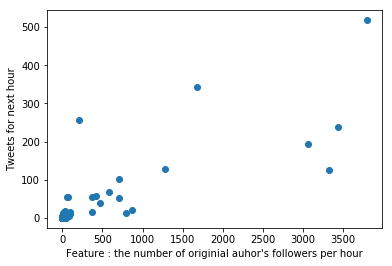

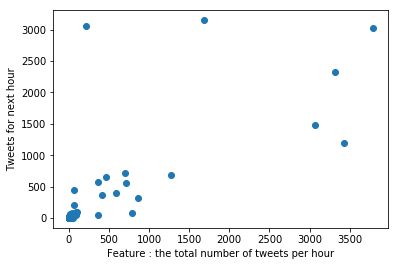

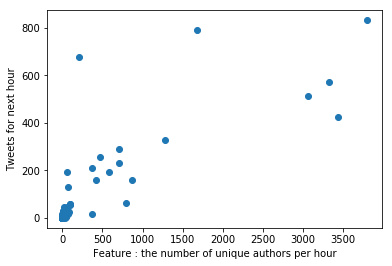

In [37]:
# top 3 features of all the features(11) according to the fitting report
# chose features with tiny p-value
# notice: const item is in the first column

feat1 = gopatriots_X_all[:,-4] # the number of urls per hour 
feat2 = gopatriots_X_all[:,-3] # the number of unique authors per hour
feat3 = gopatriots_X_all[:,-5] # the number of user mentions per hour  
feat_names = ["the number of originial auhor's followers per hour", \
              "the total number of tweets per hour", "the number of unique authors per hour"]
plot_best_feat(gopatriots_y,feat1,feat2,feat3,feat_names)

## #nfl

### 5 features

In [32]:
nfl_X_5 = Xs[2][:-1,0:5]
nfl_y = ys[2][0:-1]
nfl_model_5 = lr_model(nfl_y, nfl_X_5)
print (nfl_model_5.summary())
# RMSE
y_pre = nfl_model_5.fittedvalues
y_train = nfl_y[:-1]
#print(len(y_train),len(y_pre[:-1]))

nfl_5_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" % nfl_5_RMSE)
print("R-squared: %f \n" % nfl_model_5.rsquared)
print("p_values:\n")
print("%s\n" % nfl_model_5.pvalues)
print("t_values:\n")
print("%s\n" % nfl_model_5.tvalues)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     254.7
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.25e-143
Time:                        16:21:39   Log-Likelihood:                -4457.1
No. Observations:                 585   AIC:                             8926.
Df Residuals:                     579   BIC:                             8952.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.2879     40.915      1.742      0.0

### all features

In [33]:
nfl_X_all = Xs[2][:-1]
nfl_model = lr_model(nfl_y,nfl_X_all)
print (nfl_model.summary())

# RMSE
y_pre = nfl_model.fittedvalues
nfl_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" % nfl_RMSE)
print("R-squared: %f \n" % nfl_model.rsquared)
print("p_values:\n")
print("%s\n" % nfl_model.pvalues)
print("t_values:\n")
print("%s\n" % nfl_model.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     121.9
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          8.33e-149
Time:                        16:22:17   Log-Likelihood:                -4426.2
No. Observations:                 585   AIC:                             8878.
Df Residuals:                     572   BIC:                             8935.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -127.1124    226.688     -0.561      0.5

### plot top three features

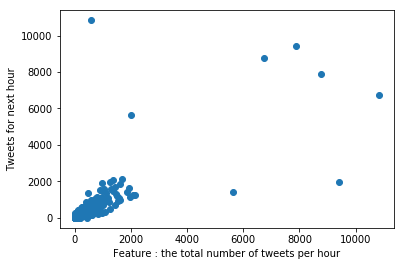

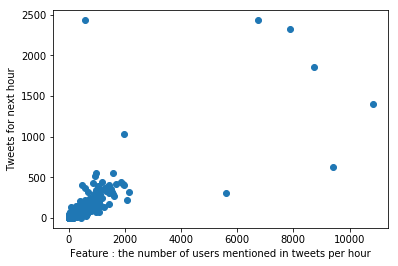

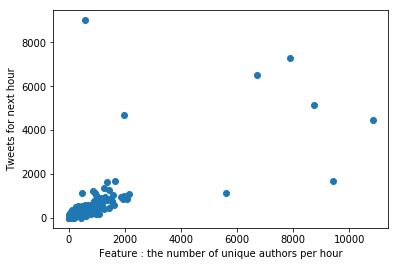

In [40]:
# top 3 features of all the features(11) according to the fitting report
# chose features with tiny p-value
# notice: const item is in the first column
feat1 = nfl_X_all[:,0] # the total number of tweets per hour
feat2 = nfl_X_all[:,-5] # the number of user mentions per hour  
feat3 = nfl_X_all[:,-3] # the number of unique authors per hour
feat_names = ["the total number of tweets per hour",\
              "the number of users mentioned in tweets per hour", \
              "the number of unique authors per hour" ]
plot_best_feat(nfl_y,feat1,feat2,feat3,feat_names)

## #patriots

### 5 features

In [35]:

patriots_X_5 = Xs[3][:-1,0:5]
patriots_y = ys[3][:-1]

patriots_model_5 = lr_model(patriots_y,patriots_X_5)
print (patriots_model_5.summary())
# RMSE
y_pre = patriots_model_5.fittedvalues
y_train = patriots_y[:-1]
patriots_5_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" % patriots_5_RMSE)
print("R-squared: %f \n" % patriots_model_5.rsquared)
print("p_values:\n")
print("%s\n" % patriots_model_5.pvalues)
print("t_values:\n")
print("%s\n" % patriots_model_5.tvalues)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     235.4
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          6.76e-137
Time:                        16:24:12   Log-Likelihood:                -5413.2
No. Observations:                 585   AIC:                         1.084e+04
Df Residuals:                     579   BIC:                         1.086e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        171.1588    204.765      0.836      0.4

### all features

In [36]:
patriots_X_all = Xs[3][:-1]
patriots_model = lr_model(patriots_y,patriots_X_all)
print (patriots_model.summary())

# RMSE
y_pre = patriots_model.fittedvalues
patriots_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
#patriots_RMSE = math.sqrt(np.mean((patriots_y - y_pre) ** 2))
print("\n")
print("RMSE: %f \n" % patriots_RMSE)
print("R-squared: %f \n" % patriots_model.rsquared)
print("p_values:\n")
print("%s\n" % patriots_model.pvalues)
print("t_values:\n")
print("%s\n" % patriots_model.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     154.2
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          2.43e-170
Time:                        16:24:59   Log-Likelihood:                -5315.6
No. Observations:                 585   AIC:                         1.066e+04
Df Residuals:                     572   BIC:                         1.071e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2158.2434   1387.371      1.556      0.1

### plot top three features

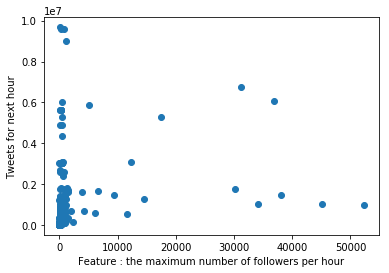

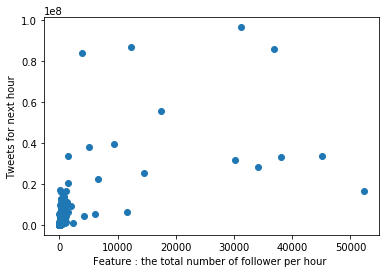

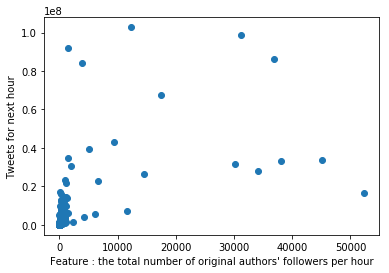

In [49]:
# top 3 features of all the features(11) according to the fitting report
# chose features with tiny p-value
# notice: const item is in the first column
feat1 = patriots_X_all[:,3] # the maximum number of followers per hour
feat2 = patriots_X_all[:,2] # the total number of followers per hour 
feat3 = patriots_X_all[:,5] # the total number of original authors' followers per hour
feat_names = [ "the maximum number of followers per hour",\
              "the total number of follower per hour ",\
              "the total number of original authors' followers per hour"]
plot_best_feat(patriots_y,feat1,feat2,feat3,feat_names)

## #sb49

### 5 features

In [37]:

sb49_X_5 = Xs[4][:-1,0:5]
sb49_y = ys[4][:-1]
sb49_model_5 = lr_model(sb49_y, sb49_X_5)
print (sb49_model_5.summary())
# RMSE
y_pre = sb49_model_5.fittedvalues
y_train = sb49_y[:-1]
#sb49_5_RMSE = math.sqrt(np.mean((sb49_y - y_pre) ** 2))
sb49_5_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" % sb49_5_RMSE)
print("R-squared: %f \n" % sb49_model_5.rsquared)
print("p_values:\n")
print("%s\n" % sb49_model_5.pvalues)
print("t_values:\n")
print("%s\n" % sb49_model_5.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     473.2
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          4.32e-201
Time:                        16:26:25   Log-Likelihood:                -5708.9
No. Observations:                 581   AIC:                         1.143e+04
Df Residuals:                     575   BIC:                         1.146e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        230.3232    366.185      0.629      0.5

### all features

In [39]:
sb49_X_all = Xs[4][:-1]
sb49_model = lr_model(sb49_y,sb49_X_all)
print (sb49_model.summary())

# RMSE
y_pre = sb49_model.fittedvalues
sb49_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" % sb49_RMSE)
print("R-squared: %f \n" % sb49_model.rsquared)
print("p_values:\n")
print("%s\n" % sb49_model.pvalues)
print("t_values:\n")
print("%s\n" % sb49_model.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     246.4
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          4.70e-216
Time:                        16:27:53   Log-Likelihood:                -5652.7
No. Observations:                 581   AIC:                         1.133e+04
Df Residuals:                     568   BIC:                         1.139e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        353.8723    633.315      0.559      0.5

### plot top three features

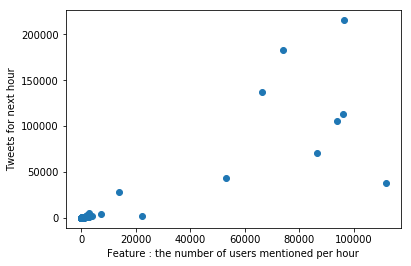

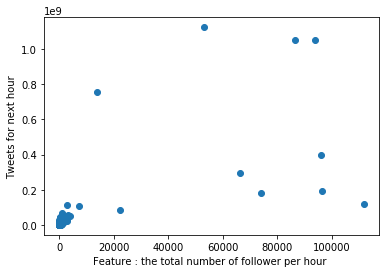

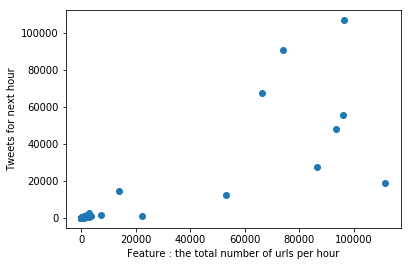

In [54]:
# top 3 features of all the features(11) according to the fitting report
# chose features with tiny p-value
# notice: const item is in the first column
feat1 = sb49_X_all[:,-5] # the number of users mentioned per hour
feat2 = sb49_X_all[:,2] # the total number of follower per hour  
feat3 = sb49_X_all[:,-4] # the total number of urls per hour
feat_names = ["the number of users mentioned per hour", \
              "the total number of follower per hour ", \
              "the total number of urls per hour"]
plot_best_feat(sb49_y,feat1,feat2,feat3,feat_names)

## #superbowl

### 5 features

In [40]:
superbowl_X_5 = Xs[5][:-1,0:5]
superbowl_y = ys[5][:-1]
superbowl_model_5 = lr_model(superbowl_y,superbowl_X_5)
print (superbowl_model_5.summary())
# RMSE
y_pre = superbowl_model_5.fittedvalues
y_train = superbowl_y[:-1]
superbowl_5_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" % superbowl_5_RMSE)
print("R-squared: %f \n" % superbowl_model_5.rsquared)
print("p_values:\n")
print("%s\n" % superbowl_model_5.pvalues)
print("t_values:\n")
print("%s\n" % superbowl_model_5.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     641.1
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          2.71e-233
Time:                        16:29:23   Log-Likelihood:                -6013.2
No. Observations:                 585   AIC:                         1.204e+04
Df Residuals:                     579   BIC:                         1.206e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -246.8265    589.757     -0.419      0.6

### all features

In [41]:
superbowl_X_all = Xs[5][:-1]
superbowl_model = lr_model(superbowl_y,superbowl_X_all)
print (superbowl_model.summary())

# RMSE
y_pre = superbowl_model.fittedvalues
superbowl_RMSE = math.sqrt(np.mean((y_train - y_pre[1:]) ** 2))
print("\n")
print("RMSE: %f \n" % superbowl_RMSE)
print("R-squared: %f \n" % superbowl_model.rsquared)
print("p_values:\n")
print("%s\n" % superbowl_model.pvalues)
print("t_values:\n")
print("%s\n" % superbowl_model.tvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     357.0
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.90e-256
Time:                        16:33:51   Log-Likelihood:                -5936.7
No. Observations:                 585   AIC:                         1.190e+04
Df Residuals:                     572   BIC:                         1.196e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3105.1934   5194.487     -0.598      0.5

### plot top three features

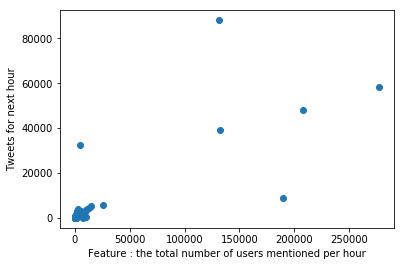

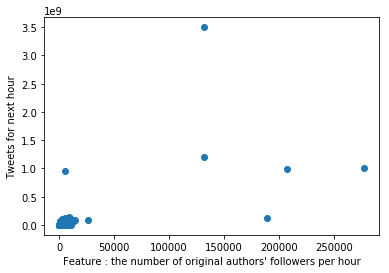

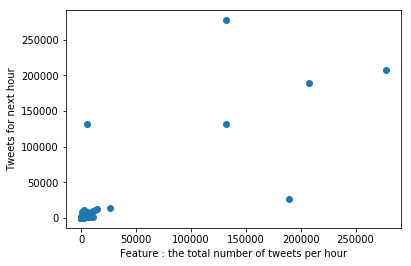

In [57]:
# top 3 features of all the features(11) according to the fitting report
# chose features with tiny p-value
# notice: const item is in the first column
feat1 = superbowl_X_all[:,-5] # the total number of users mentioned per hour 
feat2 = superbowl_X_all[:,5] # the number of original authors' followers per hour
feat3 = superbowl_X_all[:,0] # the total number of tweets per hour
feat_names = ["the total number of users mentioned per hour", \
              "the number of original authors' followers per hour", \
              "the total number of tweets per hour"]
plot_best_feat(superbowl_y,feat1,feat2,feat3,feat_names)